# READ

1. API is in User Variables for User in Environemtn Variables named "NEPTUNE_API_TOKEN"
2. If internet sucks, set mode to offline
4. When offline runs are saved locally, sync it with | neptune sync -p "New-Thesis/KFold-Test" --offline-only |
- make sure it is in venv mode | (venv) PS C:\Users\user\Documents\Machine-Learning-Hub-1\ImageClassification\Neptune-Thesis> |
5. Delete the offline folder or use | neptune clear |

# Load Libraries

In [1]:
import tqdm
import os
import cv2
import imghdr
import image_to_numpy
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import itertools
from numpy.random import default_rng

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomBrightness, Rescaling, Resizing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.metrics import F1Score, Precision, Recall, CategoricalAccuracy
from tensorboard.plugins.hparams import api as hp
import sklearn
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold

from time import perf_counter
import math

import neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback

# Initialize Functions

In [2]:
model_name = "V4.1.0"
checkpoint_path = f'./checkpoints/{model_name}/FOLD-'

In [22]:
def make_model(params):
    model = Sequential()
    model.add(RandomFlip(mode='horizontal', seed=1, input_shape=(256,256,3)))
    model.add(RandomRotation(factor=0.2, seed=1))
    
    model.add(Conv2D(input_shape=(256,256,3), filters=32, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())
    
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())
    
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())
    
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())
    
    model.add(Flatten())
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=512,activation="relu"))
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=256,activation="relu"))
    
    model.add(Dense(units=4, activation="softmax"))


    optimizer = tf.keras.optimizers.Adam(
        learning_rate=params["lr"],
    )
    
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [23]:
def create_callbacks(counter):
    neptune_cbk = NeptuneCallback(run=run, base_namespace="training")

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path + str(counter), 
                                                                 monitor='val_loss', 
                                                                 mode='auto', 
                                                                 save_best_only=True, 
                                                                 verbose=1)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                   patience=23,
                                                  )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                         factor=0.6, 
                                                         patience=10, 
                                                         min_delta=0.001, 
                                                         mode='auto', 
                                                         verbose=1)
    return [neptune_cbk, reduce_lr, cp_callback, es_callback]

In [5]:
def plot_loss(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    plt.suptitle('Loss')
    plt.legend(loc='upper right')
    plt.show()
    return fig

In [6]:
def plot_acc(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['accuracy'], color='teal', label='acc')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_acc')
    plt.suptitle('Accuracy')
    plt.legend(loc='upper left')
    plt.show()
    return fig

In [7]:
def avg_rate(metric_list):
    return sum(metric_list) / len(metric_list)

# Prepare Dataset

In [8]:
labels = ['Building', 'Plant', 'Road', 'Vehicle']
X_train = []
y_train = []
y_label_idx = []
image_size = 256
for i in labels:
    folderPath = os.path.join('D:\DATASETS\For-Thesis\Labels', i)
    for j in os.listdir(folderPath):
        img = image_to_numpy.load_image_file(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_label_idx.append(labels.index(i))

In [9]:
X_train = np.array(X_train)
y_label_idx = np.array(y_label_idx)

X_train_scaled = X_train.astype(np.float32) / 255.0

In [10]:
rng = default_rng(seed=1)

buildings_test_idx = rng.choice(np.arange(0,600), size=120, replace=False)
plants_test_idx = rng.choice(np.arange(600,1200), size=120, replace=False)
roads_test_idx = rng.choice(np.arange(1200,1800), size=120, replace=False)
vehicles_test_idx = rng.choice(np.arange(1800,2400), size=120, replace=False)
total_test_idx = np.concatenate((buildings_test_idx, plants_test_idx, roads_test_idx, vehicles_test_idx), axis=None)

In [11]:
def train_test_X(X_train_scaled):    
    test_x = X_train_scaled[total_test_idx]
    train_x = np.delete(X_train_scaled, total_test_idx, axis=0)
    return train_x, test_x

def train_test_y(y_label_idx):
    test_y = y_label_idx[total_test_idx]
    train_y = np.delete(y_label_idx, total_test_idx, axis=0)
    return train_y, test_y

In [12]:
train_x, holdout_x = train_test_X(X_train_scaled)
train_y, holdout_y = train_test_y(y_label_idx)

In [13]:
print(len(train_x), len(holdout_x))

1920 480


In [14]:
print(train_y[:5])

[0 0 0 0 0]


In [15]:
# Inidices remain the same thanks to the seed (set to 1)
# with open('total_test_idx.txt', 'w+') as f:
     
#     # write elements of list
#     for items in total_test_idx:
#         f.write('%s ' %items)
     
#     print("File written successfully")
 
 
# # close the file
# f.close()

In [16]:
# mnist = tf.keras.datasets.mnist
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train, x_test = x_train / 255.0, x_test / 255.0

# Run KFOLD

In [17]:
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=1)

In [18]:
project_name = "New-Thesis/KFold-Test"
# api_token = <It is already initialized in environemnt variables>
params = {
    "lr": 0.002, 
    "epochs": 45, 
    "batch_size": 8}

In [21]:
# run.stop()

[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: offline/57a51fc7-c4de-493d-800c-25c013e92220


Epoch 1/45


210/210 [==============================] - ETA: 0s - loss: 12.2932 - accuracy: 0.5101
Epoch 1: val_loss improved from inf to 4.76573, saving model to ./checkpoints/V4.1.0\FOLD-0
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-0\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-0\assets


210/210 [==============================] - 242s 1s/step - loss: 12.2932 - accuracy: 0.5101 - val_loss: 4.7657 - val_accuracy: 0.2500 - lr: 0.0020
Epoch 2/45
210/210 [==============================] - ETA: 0s - loss: 1.1124 - accuracy: 0.5958
Epoch 2: val_loss improved from 4.76573 to 1.64364, saving model to ./checkpoints/V4.1.0\FOLD-0
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-0\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-0\assets


210/210 [==============================] - 249s 1s/step - loss: 1.1124 - accuracy: 0.5958 - val_loss: 1.6436 - val_accuracy: 0.4333 - lr: 0.0020
Epoch 3/45
210/210 [==============================] - ETA: 0s - loss: 0.9409 - accuracy: 0.6077
Epoch 3: val_loss improved from 1.64364 to 0.76110, saving model to ./checkpoints/V4.1.0\FOLD-0
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-0\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-0\assets


210/210 [==============================] - 229s 1s/step - loss: 0.9409 - accuracy: 0.6077 - val_loss: 0.7611 - val_accuracy: 0.6167 - lr: 0.0020
Epoch 4/45
210/210 [==============================] - ETA: 0s - loss: 0.8688 - accuracy: 0.6304
Epoch 4: val_loss did not improve from 0.76110
210/210 [==============================] - 223s 1s/step - loss: 0.8688 - accuracy: 0.6304 - val_loss: 1.1795 - val_accuracy: 0.4500 - lr: 0.0020
Epoch 5/45
210/210 [==============================] - ETA: 0s - loss: 0.8532 - accuracy: 0.6464
Epoch 5: val_loss improved from 0.76110 to 0.70427, saving model to ./checkpoints/V4.1.0\FOLD-0
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-0\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-0\assets


210/210 [==============================] - 232s 1s/step - loss: 0.8532 - accuracy: 0.6464 - val_loss: 0.7043 - val_accuracy: 0.7250 - lr: 0.0020
Epoch 6/45
210/210 [==============================] - ETA: 0s - loss: 0.8948 - accuracy: 0.6679
Epoch 6: val_loss did not improve from 0.70427
210/210 [==============================] - 222s 1s/step - loss: 0.8948 - accuracy: 0.6679 - val_loss: 1.4434 - val_accuracy: 0.4875 - lr: 0.0020
Epoch 7/45
210/210 [==============================] - ETA: 0s - loss: 0.8504 - accuracy: 0.6464
Epoch 7: val_loss did not improve from 0.70427
210/210 [==============================] - 222s 1s/step - loss: 0.8504 - accuracy: 0.6464 - val_loss: 0.8963 - val_accuracy: 0.5917 - lr: 0.0020
Epoch 8/45
210/210 [==============================] - ETA: 0s - loss: 0.7632 - accuracy: 0.6798
Epoch 8: val_loss improved from 0.70427 to 0.64303, saving model to ./checkpoints/V4.1.0\FOLD-0
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-0\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-0\assets


210/210 [==============================] - 228s 1s/step - loss: 0.7632 - accuracy: 0.6798 - val_loss: 0.6430 - val_accuracy: 0.7292 - lr: 0.0020
Epoch 9/45
210/210 [==============================] - ETA: 0s - loss: 0.7094 - accuracy: 0.6893
Epoch 9: val_loss improved from 0.64303 to 0.58488, saving model to ./checkpoints/V4.1.0\FOLD-0
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-0\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-0\assets


210/210 [==============================] - 230s 1s/step - loss: 0.7094 - accuracy: 0.6893 - val_loss: 0.5849 - val_accuracy: 0.7708 - lr: 0.0020
Epoch 10/45
210/210 [==============================] - ETA: 0s - loss: 0.7333 - accuracy: 0.6994
Epoch 10: val_loss did not improve from 0.58488
210/210 [==============================] - 225s 1s/step - loss: 0.7333 - accuracy: 0.6994 - val_loss: 0.8486 - val_accuracy: 0.6042 - lr: 0.0020
Epoch 11/45
210/210 [==============================] - ETA: 0s - loss: 0.6663 - accuracy: 0.7304
Epoch 11: val_loss did not improve from 0.58488
210/210 [==============================] - 227s 1s/step - loss: 0.6663 - accuracy: 0.7304 - val_loss: 0.6483 - val_accuracy: 0.7625 - lr: 0.0020
Epoch 12/45
210/210 [==============================] - ETA: 0s - loss: 0.7046 - accuracy: 0.7155
Epoch 12: val_loss did not improve from 0.58488
210/210 [==============================] - 226s 1s/step - loss: 0.7046 - accuracy: 0.7155 - val_loss: 0.8222 - val_accuracy: 0.604

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-0\assets


210/210 [==============================] - 222s 1s/step - loss: 0.5633 - accuracy: 0.7631 - val_loss: 0.4846 - val_accuracy: 0.8083 - lr: 0.0020
Epoch 19/45
210/210 [==============================] - ETA: 0s - loss: 0.6088 - accuracy: 0.7494
Epoch 19: val_loss did not improve from 0.48461
210/210 [==============================] - 215s 1s/step - loss: 0.6088 - accuracy: 0.7494 - val_loss: 1.9437 - val_accuracy: 0.3750 - lr: 0.0020
Epoch 20/45
210/210 [==============================] - ETA: 0s - loss: 0.5828 - accuracy: 0.7756
Epoch 20: val_loss did not improve from 0.48461
210/210 [==============================] - 215s 1s/step - loss: 0.5828 - accuracy: 0.7756 - val_loss: 0.5501 - val_accuracy: 0.7583 - lr: 0.0020
Epoch 21/45
210/210 [==============================] - ETA: 0s - loss: 0.5055 - accuracy: 0.7869
Epoch 21: val_loss did not improve from 0.48461
210/210 [==============================] - 215s 1s/step - loss: 0.5055 - accuracy: 0.7869 - val_loss: 1.0120 - val_accuracy: 0.516

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-0\assets


210/210 [==============================] - 270s 1s/step - loss: 0.3384 - accuracy: 0.8744 - val_loss: 0.4669 - val_accuracy: 0.8667 - lr: 0.0012
Epoch 33/45
210/210 [==============================] - ETA: 0s - loss: 0.3281 - accuracy: 0.8833
Epoch 33: val_loss did not improve from 0.46686
210/210 [==============================] - 284s 1s/step - loss: 0.3281 - accuracy: 0.8833 - val_loss: 0.7594 - val_accuracy: 0.7083 - lr: 0.0012
Epoch 34/45
210/210 [==============================] - ETA: 0s - loss: 0.3431 - accuracy: 0.8756
Epoch 34: val_loss did not improve from 0.46686
210/210 [==============================] - 276s 1s/step - loss: 0.3431 - accuracy: 0.8756 - val_loss: 2.2038 - val_accuracy: 0.4250 - lr: 0.0012
Epoch 35/45
210/210 [==============================] - ETA: 0s - loss: 0.3153 - accuracy: 0.8851
Epoch 35: val_loss improved from 0.46686 to 0.37043, saving model to ./checkpoints/V4.1.0\FOLD-0
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-0\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-0\assets


210/210 [==============================] - 235s 1s/step - loss: 0.3153 - accuracy: 0.8851 - val_loss: 0.3704 - val_accuracy: 0.8583 - lr: 0.0012
Epoch 36/45
210/210 [==============================] - ETA: 0s - loss: 0.3152 - accuracy: 0.8768
Epoch 36: val_loss did not improve from 0.37043
210/210 [==============================] - 237s 1s/step - loss: 0.3152 - accuracy: 0.8768 - val_loss: 1.0090 - val_accuracy: 0.7042 - lr: 0.0012
Epoch 37/45
210/210 [==============================] - ETA: 0s - loss: 0.3095 - accuracy: 0.8804
Epoch 37: val_loss improved from 0.37043 to 0.32165, saving model to ./checkpoints/V4.1.0\FOLD-0
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-0\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-0\assets


210/210 [==============================] - 248s 1s/step - loss: 0.3095 - accuracy: 0.8804 - val_loss: 0.3216 - val_accuracy: 0.8792 - lr: 0.0012
Epoch 38/45
210/210 [==============================] - ETA: 0s - loss: 0.3009 - accuracy: 0.8845
Epoch 38: val_loss did not improve from 0.32165
210/210 [==============================] - 208s 993ms/step - loss: 0.3009 - accuracy: 0.8845 - val_loss: 0.4197 - val_accuracy: 0.8458 - lr: 0.0012
Epoch 39/45
210/210 [==============================] - ETA: 0s - loss: 0.3218 - accuracy: 0.8786
Epoch 39: val_loss improved from 0.32165 to 0.28557, saving model to ./checkpoints/V4.1.0\FOLD-0
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-0\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-0\assets


210/210 [==============================] - 213s 1s/step - loss: 0.3218 - accuracy: 0.8786 - val_loss: 0.2856 - val_accuracy: 0.8792 - lr: 0.0012
Epoch 40/45
210/210 [==============================] - ETA: 0s - loss: 0.2875 - accuracy: 0.8839
Epoch 40: val_loss did not improve from 0.28557
210/210 [==============================] - 205s 974ms/step - loss: 0.2875 - accuracy: 0.8839 - val_loss: 0.8131 - val_accuracy: 0.6875 - lr: 0.0012
Epoch 41/45
210/210 [==============================] - ETA: 0s - loss: 0.2704 - accuracy: 0.8952
Epoch 41: val_loss did not improve from 0.28557
210/210 [==============================] - 209s 996ms/step - loss: 0.2704 - accuracy: 0.8952 - val_loss: 0.3054 - val_accuracy: 0.8750 - lr: 0.0012
Epoch 42/45
210/210 [==============================] - ETA: 0s - loss: 0.3010 - accuracy: 0.8911
Epoch 42: val_loss did not improve from 0.28557
210/210 [==============================] - 246s 1s/step - loss: 0.3010 - accuracy: 0.8911 - val_loss: 0.8011 - val_accuracy:

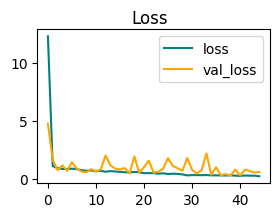

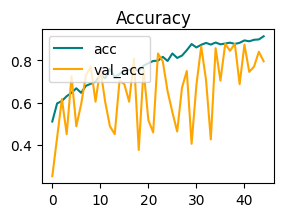

Fold Training Time: 2 hour(s) and 55 mins
Precision: 87.98283338546753  -  Recall: 85.41666865348816
Accuracy: 87.91666626930237
F1Score: Building 78.50467681884766 | Plant 92.68293762207031 | Road 96.0 | Vehicle 83.19999694824219
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/e3e441c0-588c-4d79-a2e9-308312e3ad62
Epoch 1/45
210/210 [==============================] - ETA: 0s - loss: 12.9754 - accuracy: 0.4911
Epoch 1: val_loss improved from inf to 6.28030, saving model to ./checkpoints/V4.1.0\FOLD-1
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-1\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-1\assets


210/210 [==============================] - 227s 1s/step - loss: 12.9754 - accuracy: 0.4911 - val_loss: 6.2803 - val_accuracy: 0.3208 - lr: 0.0020
Epoch 2/45
210/210 [==============================] - ETA: 0s - loss: 0.9773 - accuracy: 0.6220
Epoch 2: val_loss improved from 6.28030 to 1.02634, saving model to ./checkpoints/V4.1.0\FOLD-1
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-1\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-1\assets


210/210 [==============================] - 208s 991ms/step - loss: 0.9773 - accuracy: 0.6220 - val_loss: 1.0263 - val_accuracy: 0.5500 - lr: 0.0020
Epoch 3/45
210/210 [==============================] - ETA: 0s - loss: 0.9047 - accuracy: 0.6440
Epoch 3: val_loss did not improve from 1.02634
210/210 [==============================] - 200s 951ms/step - loss: 0.9047 - accuracy: 0.6440 - val_loss: 1.4008 - val_accuracy: 0.4417 - lr: 0.0020
Epoch 4/45
210/210 [==============================] - ETA: 0s - loss: 0.8953 - accuracy: 0.6440
Epoch 4: val_loss improved from 1.02634 to 1.01476, saving model to ./checkpoints/V4.1.0\FOLD-1
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-1\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-1\assets


210/210 [==============================] - 211s 1s/step - loss: 0.8953 - accuracy: 0.6440 - val_loss: 1.0148 - val_accuracy: 0.5500 - lr: 0.0020
Epoch 5/45
210/210 [==============================] - ETA: 0s - loss: 0.8099 - accuracy: 0.6726
Epoch 5: val_loss improved from 1.01476 to 0.89428, saving model to ./checkpoints/V4.1.0\FOLD-1
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-1\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-1\assets


210/210 [==============================] - 214s 1s/step - loss: 0.8099 - accuracy: 0.6726 - val_loss: 0.8943 - val_accuracy: 0.6417 - lr: 0.0020
Epoch 6/45
210/210 [==============================] - ETA: 0s - loss: 0.8451 - accuracy: 0.6589
Epoch 6: val_loss did not improve from 0.89428
210/210 [==============================] - 211s 1s/step - loss: 0.8451 - accuracy: 0.6589 - val_loss: 1.3042 - val_accuracy: 0.4792 - lr: 0.0020
Epoch 7/45
210/210 [==============================] - ETA: 0s - loss: 0.7811 - accuracy: 0.7048
Epoch 7: val_loss did not improve from 0.89428
210/210 [==============================] - 206s 981ms/step - loss: 0.7811 - accuracy: 0.7048 - val_loss: 1.5816 - val_accuracy: 0.4875 - lr: 0.0020
Epoch 8/45
210/210 [==============================] - ETA: 0s - loss: 0.7906 - accuracy: 0.6881
Epoch 8: val_loss did not improve from 0.89428
210/210 [==============================] - 203s 968ms/step - loss: 0.7906 - accuracy: 0.6881 - val_loss: 1.1862 - val_accuracy: 0.512

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-1\assets


210/210 [==============================] - 202s 961ms/step - loss: 0.6847 - accuracy: 0.7423 - val_loss: 0.7489 - val_accuracy: 0.7500 - lr: 0.0020
Epoch 13/45
210/210 [==============================] - ETA: 0s - loss: 0.6706 - accuracy: 0.7435
Epoch 13: val_loss improved from 0.74891 to 0.65034, saving model to ./checkpoints/V4.1.0\FOLD-1
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-1\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-1\assets


210/210 [==============================] - 202s 961ms/step - loss: 0.6706 - accuracy: 0.7435 - val_loss: 0.6503 - val_accuracy: 0.7333 - lr: 0.0020
Epoch 14/45
210/210 [==============================] - ETA: 0s - loss: 0.6247 - accuracy: 0.7607
Epoch 14: val_loss did not improve from 0.65034
210/210 [==============================] - 195s 928ms/step - loss: 0.6247 - accuracy: 0.7607 - val_loss: 0.9241 - val_accuracy: 0.6167 - lr: 0.0020
Epoch 15/45
210/210 [==============================] - ETA: 0s - loss: 0.6104 - accuracy: 0.7548
Epoch 15: val_loss did not improve from 0.65034
210/210 [==============================] - 196s 932ms/step - loss: 0.6104 - accuracy: 0.7548 - val_loss: 0.7170 - val_accuracy: 0.7208 - lr: 0.0020
Epoch 16/45
210/210 [==============================] - ETA: 0s - loss: 0.5974 - accuracy: 0.7798
Epoch 16: val_loss improved from 0.65034 to 0.45608, saving model to ./checkpoints/V4.1.0\FOLD-1
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-1\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-1\assets


210/210 [==============================] - 205s 978ms/step - loss: 0.5974 - accuracy: 0.7798 - val_loss: 0.4561 - val_accuracy: 0.8125 - lr: 0.0020
Epoch 17/45
210/210 [==============================] - ETA: 0s - loss: 0.5969 - accuracy: 0.7768
Epoch 17: val_loss did not improve from 0.45608
210/210 [==============================] - 196s 932ms/step - loss: 0.5969 - accuracy: 0.7768 - val_loss: 1.8105 - val_accuracy: 0.3583 - lr: 0.0020
Epoch 18/45
210/210 [==============================] - ETA: 0s - loss: 0.6224 - accuracy: 0.7708
Epoch 18: val_loss did not improve from 0.45608
210/210 [==============================] - 196s 933ms/step - loss: 0.6224 - accuracy: 0.7708 - val_loss: 0.5781 - val_accuracy: 0.7667 - lr: 0.0020
Epoch 19/45
210/210 [==============================] - ETA: 0s - loss: 0.5913 - accuracy: 0.7744
Epoch 19: val_loss did not improve from 0.45608
210/210 [==============================] - 195s 928ms/step - loss: 0.5913 - accuracy: 0.7744 - val_loss: 1.9725 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-1\assets


210/210 [==============================] - 202s 962ms/step - loss: 0.5163 - accuracy: 0.8024 - val_loss: 0.3941 - val_accuracy: 0.8542 - lr: 0.0020
Epoch 23/45
210/210 [==============================] - ETA: 0s - loss: 0.5323 - accuracy: 0.7869
Epoch 23: val_loss did not improve from 0.39413
210/210 [==============================] - 196s 931ms/step - loss: 0.5323 - accuracy: 0.7869 - val_loss: 0.5732 - val_accuracy: 0.7500 - lr: 0.0020
Epoch 24/45
210/210 [==============================] - ETA: 0s - loss: 0.5602 - accuracy: 0.7899
Epoch 24: val_loss did not improve from 0.39413
210/210 [==============================] - 195s 927ms/step - loss: 0.5602 - accuracy: 0.7899 - val_loss: 0.5493 - val_accuracy: 0.7708 - lr: 0.0020
Epoch 25/45
210/210 [==============================] - ETA: 0s - loss: 0.5127 - accuracy: 0.8012
Epoch 25: val_loss did not improve from 0.39413
210/210 [==============================] - 196s 933ms/step - loss: 0.5127 - accuracy: 0.8012 - val_loss: 0.8182 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-1\assets


210/210 [==============================] - 203s 967ms/step - loss: 0.3511 - accuracy: 0.8714 - val_loss: 0.3400 - val_accuracy: 0.8708 - lr: 0.0012
Epoch 37/45
210/210 [==============================] - ETA: 0s - loss: 0.3982 - accuracy: 0.8613
Epoch 37: val_loss did not improve from 0.33998
210/210 [==============================] - 195s 930ms/step - loss: 0.3982 - accuracy: 0.8613 - val_loss: 1.3033 - val_accuracy: 0.5417 - lr: 0.0012
Epoch 38/45
210/210 [==============================] - ETA: 0s - loss: 0.3960 - accuracy: 0.8500
Epoch 38: val_loss did not improve from 0.33998
210/210 [==============================] - 195s 930ms/step - loss: 0.3960 - accuracy: 0.8500 - val_loss: 1.4410 - val_accuracy: 0.5750 - lr: 0.0012
Epoch 39/45
210/210 [==============================] - ETA: 0s - loss: 0.3756 - accuracy: 0.8732
Epoch 39: val_loss did not improve from 0.33998
210/210 [==============================] - 195s 929ms/step - loss: 0.3756 - accuracy: 0.8732 - val_loss: 0.7866 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-1\assets


210/210 [==============================] - 206s 983ms/step - loss: 0.4247 - accuracy: 0.8625 - val_loss: 0.3160 - val_accuracy: 0.8958 - lr: 0.0012
Epoch 43/45
210/210 [==============================] - ETA: 0s - loss: 0.3570 - accuracy: 0.8756
Epoch 43: val_loss did not improve from 0.31599
210/210 [==============================] - 203s 964ms/step - loss: 0.3570 - accuracy: 0.8756 - val_loss: 0.4536 - val_accuracy: 0.8250 - lr: 0.0012
Epoch 44/45
210/210 [==============================] - ETA: 0s - loss: 0.3392 - accuracy: 0.8732
Epoch 44: val_loss did not improve from 0.31599
210/210 [==============================] - 201s 957ms/step - loss: 0.3392 - accuracy: 0.8732 - val_loss: 0.4096 - val_accuracy: 0.8333 - lr: 0.0012
Epoch 45/45
210/210 [==============================] - ETA: 0s - loss: 0.3056 - accuracy: 0.8893
Epoch 45: val_loss did not improve from 0.31599
210/210 [==============================] - 211s 1s/step - loss: 0.3056 - accuracy: 0.8893 - val_loss: 0.4934 - val_accura

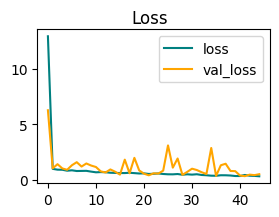

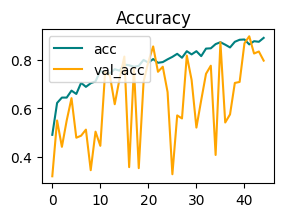

Fold Training Time: 2 hour(s) and 30 mins
Precision: 90.82969427108765  -  Recall: 86.66666746139526
Accuracy: 89.58333134651184
F1Score: Building 81.96721649169922 | Plant 94.48818969726562 | Road 97.4358901977539 | Vehicle 84.21052551269531
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/475243e6-9b35-4f89-9864-701ea96b2c7b
Epoch 1/45
210/210 [==============================] - ETA: 0s - loss: 12.1039 - accuracy: 0.5155
Epoch 1: val_loss improved from inf to 3.43069, saving model to ./checkpoints/V4.1.0\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-2\assets


210/210 [==============================] - 223s 1s/step - loss: 12.1039 - accuracy: 0.5155 - val_loss: 3.4307 - val_accuracy: 0.2542 - lr: 0.0020
Epoch 2/45
210/210 [==============================] - ETA: 0s - loss: 1.0227 - accuracy: 0.6012
Epoch 2: val_loss improved from 3.43069 to 1.08888, saving model to ./checkpoints/V4.1.0\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-2\assets


210/210 [==============================] - 236s 1s/step - loss: 1.0227 - accuracy: 0.6012 - val_loss: 1.0889 - val_accuracy: 0.4667 - lr: 0.0020
Epoch 3/45
210/210 [==============================] - ETA: 0s - loss: 0.9796 - accuracy: 0.6024
Epoch 3: val_loss improved from 1.08888 to 1.06896, saving model to ./checkpoints/V4.1.0\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-2\assets


210/210 [==============================] - 214s 1s/step - loss: 0.9796 - accuracy: 0.6024 - val_loss: 1.0690 - val_accuracy: 0.6000 - lr: 0.0020
Epoch 4/45
210/210 [==============================] - ETA: 0s - loss: 1.0347 - accuracy: 0.5613
Epoch 4: val_loss did not improve from 1.06896
210/210 [==============================] - 208s 992ms/step - loss: 1.0347 - accuracy: 0.5613 - val_loss: 1.6641 - val_accuracy: 0.4542 - lr: 0.0020
Epoch 5/45
210/210 [==============================] - ETA: 0s - loss: 1.0534 - accuracy: 0.5726
Epoch 5: val_loss did not improve from 1.06896
210/210 [==============================] - 195s 927ms/step - loss: 1.0534 - accuracy: 0.5726 - val_loss: 8.0625 - val_accuracy: 0.3208 - lr: 0.0020
Epoch 6/45
210/210 [==============================] - ETA: 0s - loss: 1.0944 - accuracy: 0.5274
Epoch 6: val_loss did not improve from 1.06896
210/210 [==============================] - 209s 993ms/step - loss: 1.0944 - accuracy: 0.5274 - val_loss: 1.6094 - val_accuracy: 0.

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-2\assets


210/210 [==============================] - 187s 891ms/step - loss: 1.0742 - accuracy: 0.5482 - val_loss: 1.0023 - val_accuracy: 0.5708 - lr: 0.0020
Epoch 10/45
210/210 [==============================] - ETA: 0s - loss: 1.0608 - accuracy: 0.5500
Epoch 10: val_loss did not improve from 1.00232
210/210 [==============================] - 178s 846ms/step - loss: 1.0608 - accuracy: 0.5500 - val_loss: 14.6310 - val_accuracy: 0.2667 - lr: 0.0020
Epoch 11/45
210/210 [==============================] - ETA: 0s - loss: 1.0530 - accuracy: 0.5429
Epoch 11: val_loss improved from 1.00232 to 0.93738, saving model to ./checkpoints/V4.1.0\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-2\assets


210/210 [==============================] - 186s 886ms/step - loss: 1.0530 - accuracy: 0.5429 - val_loss: 0.9374 - val_accuracy: 0.5792 - lr: 0.0020
Epoch 12/45
210/210 [==============================] - ETA: 0s - loss: 1.0147 - accuracy: 0.5524
Epoch 12: val_loss did not improve from 0.93738
210/210 [==============================] - 178s 846ms/step - loss: 1.0147 - accuracy: 0.5524 - val_loss: 0.9896 - val_accuracy: 0.6292 - lr: 0.0020
Epoch 13/45
210/210 [==============================] - ETA: 0s - loss: 0.9321 - accuracy: 0.5619
Epoch 13: val_loss did not improve from 0.93738
210/210 [==============================] - 177s 843ms/step - loss: 0.9321 - accuracy: 0.5619 - val_loss: 1.0604 - val_accuracy: 0.4958 - lr: 0.0020
Epoch 14/45
210/210 [==============================] - ETA: 0s - loss: 0.9370 - accuracy: 0.5720
Epoch 14: val_loss did not improve from 0.93738
210/210 [==============================] - 178s 846ms/step - loss: 0.9370 - accuracy: 0.5720 - val_loss: 1.8777 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-2\assets


210/210 [==============================] - 184s 877ms/step - loss: 0.9458 - accuracy: 0.5839 - val_loss: 0.8593 - val_accuracy: 0.6417 - lr: 0.0020
Epoch 21/45
210/210 [==============================] - ETA: 0s - loss: 0.8888 - accuracy: 0.5827
Epoch 21: val_loss did not improve from 0.85931
210/210 [==============================] - 177s 845ms/step - loss: 0.8888 - accuracy: 0.5827 - val_loss: 0.8928 - val_accuracy: 0.5542 - lr: 0.0020
Epoch 22/45
210/210 [==============================] - ETA: 0s - loss: 0.8846 - accuracy: 0.5708
Epoch 22: val_loss did not improve from 0.85931
210/210 [==============================] - 177s 845ms/step - loss: 0.8846 - accuracy: 0.5708 - val_loss: 1.0481 - val_accuracy: 0.5708 - lr: 0.0020
Epoch 23/45
210/210 [==============================] - ETA: 0s - loss: 0.8825 - accuracy: 0.5964
Epoch 23: val_loss did not improve from 0.85931
210/210 [==============================] - 177s 844ms/step - loss: 0.8825 - accuracy: 0.5964 - val_loss: 1.6178 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-2\assets


210/210 [==============================] - 185s 879ms/step - loss: 0.9557 - accuracy: 0.5792 - val_loss: 0.7178 - val_accuracy: 0.6792 - lr: 0.0020
Epoch 29/45
210/210 [==============================] - ETA: 0s - loss: 0.7825 - accuracy: 0.6375
Epoch 29: val_loss did not improve from 0.71779
210/210 [==============================] - 178s 850ms/step - loss: 0.7825 - accuracy: 0.6375 - val_loss: 0.8082 - val_accuracy: 0.6042 - lr: 0.0020
Epoch 30/45
210/210 [==============================] - ETA: 0s - loss: 0.8477 - accuracy: 0.6185
Epoch 30: val_loss did not improve from 0.71779
210/210 [==============================] - 178s 846ms/step - loss: 0.8477 - accuracy: 0.6185 - val_loss: 1.1360 - val_accuracy: 0.5750 - lr: 0.0020
Epoch 31/45
210/210 [==============================] - ETA: 0s - loss: 0.8086 - accuracy: 0.6190
Epoch 31: val_loss did not improve from 0.71779
210/210 [==============================] - 178s 846ms/step - loss: 0.8086 - accuracy: 0.6190 - val_loss: 0.7579 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-2\assets


210/210 [==============================] - 184s 876ms/step - loss: 0.6516 - accuracy: 0.6833 - val_loss: 0.7109 - val_accuracy: 0.6542 - lr: 0.0020
Epoch 37/45
210/210 [==============================] - ETA: 0s - loss: 0.7773 - accuracy: 0.6286
Epoch 37: val_loss did not improve from 0.71088
210/210 [==============================] - 177s 845ms/step - loss: 0.7773 - accuracy: 0.6286 - val_loss: 1.5235 - val_accuracy: 0.4083 - lr: 0.0020
Epoch 38/45
210/210 [==============================] - ETA: 0s - loss: 0.7065 - accuracy: 0.6518
Epoch 38: val_loss did not improve from 0.71088
210/210 [==============================] - 177s 843ms/step - loss: 0.7065 - accuracy: 0.6518 - val_loss: 1.3213 - val_accuracy: 0.4750 - lr: 0.0020
Epoch 39/45
210/210 [==============================] - ETA: 0s - loss: 0.6916 - accuracy: 0.6565
Epoch 39: val_loss improved from 0.71088 to 0.64556, saving model to ./checkpoints/V4.1.0\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-2\assets


210/210 [==============================] - 185s 881ms/step - loss: 0.6916 - accuracy: 0.6565 - val_loss: 0.6456 - val_accuracy: 0.6750 - lr: 0.0020
Epoch 40/45
210/210 [==============================] - ETA: 0s - loss: 0.6500 - accuracy: 0.6732
Epoch 40: val_loss did not improve from 0.64556
210/210 [==============================] - 177s 843ms/step - loss: 0.6500 - accuracy: 0.6732 - val_loss: 1.0805 - val_accuracy: 0.5708 - lr: 0.0020
Epoch 41/45
210/210 [==============================] - ETA: 0s - loss: 0.7252 - accuracy: 0.6631
Epoch 41: val_loss did not improve from 0.64556
210/210 [==============================] - 177s 842ms/step - loss: 0.7252 - accuracy: 0.6631 - val_loss: 0.8466 - val_accuracy: 0.6125 - lr: 0.0020
Epoch 42/45
210/210 [==============================] - ETA: 0s - loss: 0.7593 - accuracy: 0.6482
Epoch 42: val_loss did not improve from 0.64556
210/210 [==============================] - 177s 845ms/step - loss: 0.7593 - accuracy: 0.6482 - val_loss: 0.9800 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-2\assets


210/210 [==============================] - 185s 880ms/step - loss: 0.7497 - accuracy: 0.6554 - val_loss: 0.6027 - val_accuracy: 0.6917 - lr: 0.0020
Epoch 44/45
210/210 [==============================] - ETA: 0s - loss: 0.7045 - accuracy: 0.6696
Epoch 44: val_loss did not improve from 0.60272
210/210 [==============================] - 177s 844ms/step - loss: 0.7045 - accuracy: 0.6696 - val_loss: 1.0813 - val_accuracy: 0.5375 - lr: 0.0020
Epoch 45/45
210/210 [==============================] - ETA: 0s - loss: 0.7270 - accuracy: 0.6589
Epoch 45: val_loss did not improve from 0.60272
210/210 [==============================] - 178s 847ms/step - loss: 0.7270 - accuracy: 0.6589 - val_loss: 1.0095 - val_accuracy: 0.5792 - lr: 0.0020


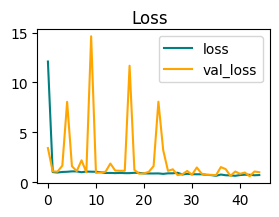

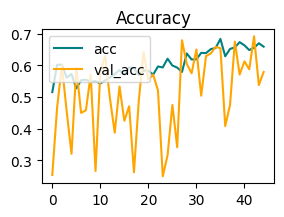

Fold Training Time: 2 hour(s) and 18 mins
Precision: 70.31963467597961  -  Recall: 64.16666507720947
Accuracy: 69.16666626930237
F1Score: Building 14.084507942199707 | Plant 87.02290344238281 | Road 87.2727279663086 | Vehicle 66.66667175292969
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/48b4c3e3-5bd1-4bb0-abe1-441c729396a6
Epoch 1/45
210/210 [==============================] - ETA: 0s - loss: 10.8313 - accuracy: 0.5685
Epoch 1: val_loss improved from inf to 4.88745, saving model to ./checkpoints/V4.1.0\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-3\assets


210/210 [==============================] - 197s 917ms/step - loss: 10.8313 - accuracy: 0.5685 - val_loss: 4.8875 - val_accuracy: 0.2875 - lr: 0.0020
Epoch 2/45
210/210 [==============================] - ETA: 0s - loss: 1.0311 - accuracy: 0.6429
Epoch 2: val_loss improved from 4.88745 to 1.34543, saving model to ./checkpoints/V4.1.0\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-3\assets


210/210 [==============================] - 188s 897ms/step - loss: 1.0311 - accuracy: 0.6429 - val_loss: 1.3454 - val_accuracy: 0.4083 - lr: 0.0020
Epoch 3/45
210/210 [==============================] - ETA: 0s - loss: 1.0669 - accuracy: 0.5548
Epoch 3: val_loss improved from 1.34543 to 0.81801, saving model to ./checkpoints/V4.1.0\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-3\assets


210/210 [==============================] - 190s 904ms/step - loss: 1.0669 - accuracy: 0.5548 - val_loss: 0.8180 - val_accuracy: 0.6667 - lr: 0.0020
Epoch 4/45
210/210 [==============================] - ETA: 0s - loss: 1.1095 - accuracy: 0.5131
Epoch 4: val_loss did not improve from 0.81801
210/210 [==============================] - 184s 875ms/step - loss: 1.1095 - accuracy: 0.5131 - val_loss: 1.0984 - val_accuracy: 0.6167 - lr: 0.0020
Epoch 5/45
210/210 [==============================] - ETA: 0s - loss: 1.0048 - accuracy: 0.5905
Epoch 5: val_loss did not improve from 0.81801
210/210 [==============================] - 181s 863ms/step - loss: 1.0048 - accuracy: 0.5905 - val_loss: 1.0384 - val_accuracy: 0.5542 - lr: 0.0020
Epoch 6/45
210/210 [==============================] - ETA: 0s - loss: 1.0598 - accuracy: 0.5756
Epoch 6: val_loss did not improve from 0.81801
210/210 [==============================] - 184s 878ms/step - loss: 1.0598 - accuracy: 0.5756 - val_loss: 1.2457 - val_accuracy:

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-3\assets


210/210 [==============================] - 188s 897ms/step - loss: 0.6964 - accuracy: 0.7125 - val_loss: 0.6984 - val_accuracy: 0.7125 - lr: 0.0012
Epoch 17/45
210/210 [==============================] - ETA: 0s - loss: 0.7077 - accuracy: 0.7298
Epoch 17: val_loss did not improve from 0.69839
210/210 [==============================] - 182s 869ms/step - loss: 0.7077 - accuracy: 0.7298 - val_loss: 0.9418 - val_accuracy: 0.6167 - lr: 0.0012
Epoch 18/45
210/210 [==============================] - ETA: 0s - loss: 0.7166 - accuracy: 0.7101
Epoch 18: val_loss did not improve from 0.69839
210/210 [==============================] - 181s 863ms/step - loss: 0.7166 - accuracy: 0.7101 - val_loss: 0.9715 - val_accuracy: 0.6000 - lr: 0.0012
Epoch 19/45
210/210 [==============================] - ETA: 0s - loss: 0.6916 - accuracy: 0.7244
Epoch 19: val_loss did not improve from 0.69839
210/210 [==============================] - 181s 863ms/step - loss: 0.6916 - accuracy: 0.7244 - val_loss: 0.7465 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-3\assets


210/210 [==============================] - 194s 924ms/step - loss: 0.6507 - accuracy: 0.7351 - val_loss: 0.5676 - val_accuracy: 0.7542 - lr: 0.0012
Epoch 22/45
210/210 [==============================] - ETA: 0s - loss: 0.6961 - accuracy: 0.7185
Epoch 22: val_loss did not improve from 0.56762
210/210 [==============================] - 182s 868ms/step - loss: 0.6961 - accuracy: 0.7185 - val_loss: 0.7317 - val_accuracy: 0.7125 - lr: 0.0012
Epoch 23/45
210/210 [==============================] - ETA: 0s - loss: 0.6310 - accuracy: 0.7351
Epoch 23: val_loss improved from 0.56762 to 0.52621, saving model to ./checkpoints/V4.1.0\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-3\assets


210/210 [==============================] - 190s 906ms/step - loss: 0.6310 - accuracy: 0.7351 - val_loss: 0.5262 - val_accuracy: 0.7958 - lr: 0.0012
Epoch 24/45
210/210 [==============================] - ETA: 0s - loss: 0.6222 - accuracy: 0.7476
Epoch 24: val_loss did not improve from 0.52621
210/210 [==============================] - 182s 868ms/step - loss: 0.6222 - accuracy: 0.7476 - val_loss: 0.7519 - val_accuracy: 0.7292 - lr: 0.0012
Epoch 25/45
210/210 [==============================] - ETA: 0s - loss: 0.6052 - accuracy: 0.7625
Epoch 25: val_loss improved from 0.52621 to 0.50126, saving model to ./checkpoints/V4.1.0\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-3\assets


210/210 [==============================] - 188s 897ms/step - loss: 0.6052 - accuracy: 0.7625 - val_loss: 0.5013 - val_accuracy: 0.8167 - lr: 0.0012
Epoch 26/45
210/210 [==============================] - ETA: 0s - loss: 0.5790 - accuracy: 0.7780
Epoch 26: val_loss did not improve from 0.50126
210/210 [==============================] - 182s 868ms/step - loss: 0.5790 - accuracy: 0.7780 - val_loss: 0.5921 - val_accuracy: 0.8000 - lr: 0.0012
Epoch 27/45
210/210 [==============================] - ETA: 0s - loss: 0.6042 - accuracy: 0.7696
Epoch 27: val_loss did not improve from 0.50126
210/210 [==============================] - 182s 864ms/step - loss: 0.6042 - accuracy: 0.7696 - val_loss: 1.0113 - val_accuracy: 0.6250 - lr: 0.0012
Epoch 28/45
210/210 [==============================] - ETA: 0s - loss: 0.5958 - accuracy: 0.7708
Epoch 28: val_loss did not improve from 0.50126
210/210 [==============================] - 181s 862ms/step - loss: 0.5958 - accuracy: 0.7708 - val_loss: 1.1516 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-3\assets


210/210 [==============================] - 189s 898ms/step - loss: 0.4602 - accuracy: 0.8244 - val_loss: 0.4568 - val_accuracy: 0.8333 - lr: 0.0012
Epoch 35/45
210/210 [==============================] - ETA: 0s - loss: 0.4528 - accuracy: 0.8327
Epoch 35: val_loss improved from 0.45677 to 0.41880, saving model to ./checkpoints/V4.1.0\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-3\assets


210/210 [==============================] - 188s 895ms/step - loss: 0.4528 - accuracy: 0.8327 - val_loss: 0.4188 - val_accuracy: 0.8375 - lr: 0.0012
Epoch 36/45
210/210 [==============================] - ETA: 0s - loss: 0.4391 - accuracy: 0.8262
Epoch 36: val_loss did not improve from 0.41880
210/210 [==============================] - 182s 866ms/step - loss: 0.4391 - accuracy: 0.8262 - val_loss: 0.5549 - val_accuracy: 0.8042 - lr: 0.0012
Epoch 37/45
210/210 [==============================] - ETA: 0s - loss: 0.4490 - accuracy: 0.8286
Epoch 37: val_loss did not improve from 0.41880
210/210 [==============================] - 182s 865ms/step - loss: 0.4490 - accuracy: 0.8286 - val_loss: 0.4707 - val_accuracy: 0.8083 - lr: 0.0012
Epoch 38/45
210/210 [==============================] - ETA: 0s - loss: 0.4365 - accuracy: 0.8345
Epoch 38: val_loss did not improve from 0.41880
210/210 [==============================] - 181s 864ms/step - loss: 0.4365 - accuracy: 0.8345 - val_loss: 0.4838 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-3\assets


210/210 [==============================] - 190s 904ms/step - loss: 0.3823 - accuracy: 0.8619 - val_loss: 0.3528 - val_accuracy: 0.8458 - lr: 0.0012
Epoch 45/45
210/210 [==============================] - ETA: 0s - loss: 0.3628 - accuracy: 0.8685
Epoch 45: val_loss did not improve from 0.35279
210/210 [==============================] - 181s 863ms/step - loss: 0.3628 - accuracy: 0.8685 - val_loss: 0.3759 - val_accuracy: 0.8375 - lr: 0.0012


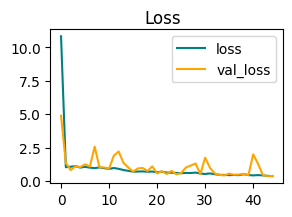

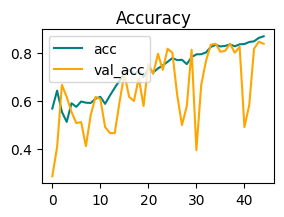

Fold Training Time: 2 hour(s) and 18 mins
Precision: 89.04109597206116  -  Recall: 81.25
Accuracy: 84.58333611488342
F1Score: Building 76.9230728149414 | Plant 91.47286224365234 | Road 88.6956558227539 | Vehicle 80.67227172851562
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/b8ac00ef-8295-464a-97f1-366e72d088ad
Epoch 1/45
210/210 [==============================] - ETA: 0s - loss: 14.0007 - accuracy: 0.5119
Epoch 1: val_loss improved from inf to 3.78376, saving model to ./checkpoints/V4.1.0\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-4\assets


210/210 [==============================] - 194s 903ms/step - loss: 14.0007 - accuracy: 0.5119 - val_loss: 3.7838 - val_accuracy: 0.2542 - lr: 0.0020
Epoch 2/45
210/210 [==============================] - ETA: 0s - loss: 1.0927 - accuracy: 0.5964
Epoch 2: val_loss improved from 3.78376 to 1.04833, saving model to ./checkpoints/V4.1.0\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-4\assets


210/210 [==============================] - 188s 898ms/step - loss: 1.0927 - accuracy: 0.5964 - val_loss: 1.0483 - val_accuracy: 0.5083 - lr: 0.0020
Epoch 3/45
210/210 [==============================] - ETA: 0s - loss: 0.8597 - accuracy: 0.6387
Epoch 3: val_loss improved from 1.04833 to 0.76001, saving model to ./checkpoints/V4.1.0\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-4\assets


210/210 [==============================] - 191s 908ms/step - loss: 0.8597 - accuracy: 0.6387 - val_loss: 0.7600 - val_accuracy: 0.7042 - lr: 0.0020
Epoch 4/45
210/210 [==============================] - ETA: 0s - loss: 0.8616 - accuracy: 0.6500
Epoch 4: val_loss did not improve from 0.76001
210/210 [==============================] - 186s 884ms/step - loss: 0.8616 - accuracy: 0.6500 - val_loss: 0.8979 - val_accuracy: 0.6167 - lr: 0.0020
Epoch 5/45
210/210 [==============================] - ETA: 0s - loss: 0.7975 - accuracy: 0.6583
Epoch 5: val_loss did not improve from 0.76001
210/210 [==============================] - 184s 878ms/step - loss: 0.7975 - accuracy: 0.6583 - val_loss: 1.2844 - val_accuracy: 0.6750 - lr: 0.0020
Epoch 6/45
210/210 [==============================] - ETA: 0s - loss: 0.8259 - accuracy: 0.6613
Epoch 6: val_loss did not improve from 0.76001
210/210 [==============================] - 183s 874ms/step - loss: 0.8259 - accuracy: 0.6613 - val_loss: 1.2894 - val_accuracy:

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-4\assets


210/210 [==============================] - 190s 907ms/step - loss: 0.8049 - accuracy: 0.6661 - val_loss: 0.6793 - val_accuracy: 0.7542 - lr: 0.0020
Epoch 8/45
210/210 [==============================] - ETA: 0s - loss: 0.8262 - accuracy: 0.6702
Epoch 8: val_loss did not improve from 0.67930
210/210 [==============================] - 183s 872ms/step - loss: 0.8262 - accuracy: 0.6702 - val_loss: 11.0894 - val_accuracy: 0.3000 - lr: 0.0020
Epoch 9/45
210/210 [==============================] - ETA: 0s - loss: 0.7972 - accuracy: 0.6679
Epoch 9: val_loss did not improve from 0.67930
210/210 [==============================] - 183s 873ms/step - loss: 0.7972 - accuracy: 0.6679 - val_loss: 4.2477 - val_accuracy: 0.4917 - lr: 0.0020
Epoch 10/45
210/210 [==============================] - ETA: 0s - loss: 0.7878 - accuracy: 0.6887
Epoch 10: val_loss did not improve from 0.67930
210/210 [==============================] - 183s 873ms/step - loss: 0.7878 - accuracy: 0.6887 - val_loss: 0.7926 - val_accura

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-4\assets


210/210 [==============================] - 191s 908ms/step - loss: 0.7444 - accuracy: 0.7042 - val_loss: 0.6733 - val_accuracy: 0.7792 - lr: 0.0020
Epoch 14/45
210/210 [==============================] - ETA: 0s - loss: 0.6481 - accuracy: 0.7452
Epoch 14: val_loss did not improve from 0.67326
210/210 [==============================] - 184s 878ms/step - loss: 0.6481 - accuracy: 0.7452 - val_loss: 0.7290 - val_accuracy: 0.7542 - lr: 0.0020
Epoch 15/45
210/210 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.7405
Epoch 15: val_loss did not improve from 0.67326
210/210 [==============================] - 184s 878ms/step - loss: 0.6942 - accuracy: 0.7405 - val_loss: 1.6740 - val_accuracy: 0.3917 - lr: 0.0020
Epoch 16/45
210/210 [==============================] - ETA: 0s - loss: 0.6473 - accuracy: 0.7405
Epoch 16: val_loss did not improve from 0.67326
210/210 [==============================] - 184s 875ms/step - loss: 0.6473 - accuracy: 0.7405 - val_loss: 3.0978 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-4\assets


210/210 [==============================] - 191s 909ms/step - loss: 0.5471 - accuracy: 0.7827 - val_loss: 0.6478 - val_accuracy: 0.7708 - lr: 0.0020
Epoch 23/45
210/210 [==============================] - ETA: 0s - loss: 0.5251 - accuracy: 0.8000
Epoch 23: val_loss did not improve from 0.64780
210/210 [==============================] - 183s 871ms/step - loss: 0.5251 - accuracy: 0.8000 - val_loss: 0.8136 - val_accuracy: 0.7625 - lr: 0.0020
Epoch 24/45
210/210 [==============================] - ETA: 0s - loss: 0.5624 - accuracy: 0.7851
Epoch 24: val_loss improved from 0.64780 to 0.55762, saving model to ./checkpoints/V4.1.0\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-4\assets


210/210 [==============================] - 191s 911ms/step - loss: 0.5624 - accuracy: 0.7851 - val_loss: 0.5576 - val_accuracy: 0.7958 - lr: 0.0020
Epoch 25/45
210/210 [==============================] - ETA: 0s - loss: 0.5843 - accuracy: 0.7786
Epoch 25: val_loss did not improve from 0.55762
210/210 [==============================] - 183s 869ms/step - loss: 0.5843 - accuracy: 0.7786 - val_loss: 1.2599 - val_accuracy: 0.5875 - lr: 0.0020
Epoch 26/45
210/210 [==============================] - ETA: 0s - loss: 0.4921 - accuracy: 0.8042
Epoch 26: val_loss did not improve from 0.55762
210/210 [==============================] - 183s 874ms/step - loss: 0.4921 - accuracy: 0.8042 - val_loss: 0.8972 - val_accuracy: 0.6750 - lr: 0.0020
Epoch 27/45
210/210 [==============================] - ETA: 0s - loss: 0.4818 - accuracy: 0.8173
Epoch 27: val_loss did not improve from 0.55762
210/210 [==============================] - 184s 876ms/step - loss: 0.4818 - accuracy: 0.8173 - val_loss: 0.8075 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-4\assets


210/210 [==============================] - 192s 915ms/step - loss: 0.4872 - accuracy: 0.8131 - val_loss: 0.5219 - val_accuracy: 0.8375 - lr: 0.0020
Epoch 30/45
210/210 [==============================] - ETA: 0s - loss: 0.4722 - accuracy: 0.8208
Epoch 30: val_loss did not improve from 0.52189
210/210 [==============================] - 184s 876ms/step - loss: 0.4722 - accuracy: 0.8208 - val_loss: 1.3651 - val_accuracy: 0.4250 - lr: 0.0020
Epoch 31/45
210/210 [==============================] - ETA: 0s - loss: 0.5016 - accuracy: 0.8161
Epoch 31: val_loss improved from 0.52189 to 0.45870, saving model to ./checkpoints/V4.1.0\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-4\assets


210/210 [==============================] - 190s 907ms/step - loss: 0.5016 - accuracy: 0.8161 - val_loss: 0.4587 - val_accuracy: 0.8625 - lr: 0.0020
Epoch 32/45
210/210 [==============================] - ETA: 0s - loss: 0.4873 - accuracy: 0.8101
Epoch 32: val_loss did not improve from 0.45870
210/210 [==============================] - 183s 872ms/step - loss: 0.4873 - accuracy: 0.8101 - val_loss: 0.7057 - val_accuracy: 0.7792 - lr: 0.0020
Epoch 33/45
210/210 [==============================] - ETA: 0s - loss: 0.4411 - accuracy: 0.8381
Epoch 33: val_loss did not improve from 0.45870
210/210 [==============================] - 184s 877ms/step - loss: 0.4411 - accuracy: 0.8381 - val_loss: 0.9093 - val_accuracy: 0.7250 - lr: 0.0020
Epoch 34/45
210/210 [==============================] - ETA: 0s - loss: 0.4702 - accuracy: 0.8190
Epoch 34: val_loss did not improve from 0.45870
210/210 [==============================] - 185s 879ms/step - loss: 0.4702 - accuracy: 0.8190 - val_loss: 0.8738 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-4\assets


210/210 [==============================] - 192s 914ms/step - loss: 0.4877 - accuracy: 0.8208 - val_loss: 0.4067 - val_accuracy: 0.9000 - lr: 0.0020
Epoch 42/45
210/210 [==============================] - ETA: 0s - loss: 0.4294 - accuracy: 0.8458
Epoch 42: val_loss did not improve from 0.40673
210/210 [==============================] - 183s 873ms/step - loss: 0.4294 - accuracy: 0.8458 - val_loss: 0.5399 - val_accuracy: 0.8000 - lr: 0.0020
Epoch 43/45
210/210 [==============================] - ETA: 0s - loss: 0.5326 - accuracy: 0.8131
Epoch 43: val_loss did not improve from 0.40673
210/210 [==============================] - 185s 880ms/step - loss: 0.5326 - accuracy: 0.8131 - val_loss: 0.6433 - val_accuracy: 0.7625 - lr: 0.0020
Epoch 44/45
210/210 [==============================] - ETA: 0s - loss: 0.4204 - accuracy: 0.8435
Epoch 44: val_loss did not improve from 0.40673
210/210 [==============================] - 184s 875ms/step - loss: 0.4204 - accuracy: 0.8435 - val_loss: 0.4348 - val_acc

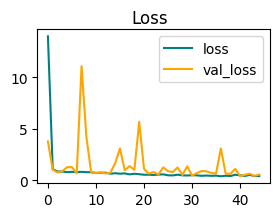

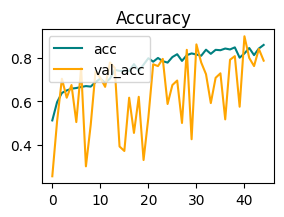

Fold Training Time: 2 hour(s) and 19 mins
Precision: 93.68932247161865  -  Recall: 80.41666746139526
Accuracy: 89.99999761581421
F1Score: Building 85.0 | Plant 93.442626953125 | Road 92.17391967773438 | Vehicle 89.43089294433594
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/b9cee021-d264-4bc0-bee7-e96b0a5380da
Epoch 1/45
210/210 [==============================] - ETA: 0s - loss: 18.1343 - accuracy: 0.4595
Epoch 1: val_loss improved from inf to 2.80447, saving model to ./checkpoints/V4.1.0\FOLD-5
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-5\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-5\assets


210/210 [==============================] - 193s 895ms/step - loss: 18.1343 - accuracy: 0.4595 - val_loss: 2.8045 - val_accuracy: 0.2500 - lr: 0.0020
Epoch 2/45
210/210 [==============================] - ETA: 0s - loss: 1.2123 - accuracy: 0.5571
Epoch 2: val_loss improved from 2.80447 to 1.20871, saving model to ./checkpoints/V4.1.0\FOLD-5
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-5\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-5\assets


210/210 [==============================] - 188s 895ms/step - loss: 1.2123 - accuracy: 0.5571 - val_loss: 1.2087 - val_accuracy: 0.5167 - lr: 0.0020
Epoch 3/45
210/210 [==============================] - ETA: 0s - loss: 1.0092 - accuracy: 0.5905
Epoch 3: val_loss improved from 1.20871 to 0.65290, saving model to ./checkpoints/V4.1.0\FOLD-5
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-5\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-5\assets


210/210 [==============================] - 191s 908ms/step - loss: 1.0092 - accuracy: 0.5905 - val_loss: 0.6529 - val_accuracy: 0.7250 - lr: 0.0020
Epoch 4/45
210/210 [==============================] - ETA: 0s - loss: 1.0337 - accuracy: 0.5929
Epoch 4: val_loss did not improve from 0.65290
210/210 [==============================] - 182s 868ms/step - loss: 1.0337 - accuracy: 0.5929 - val_loss: 0.8543 - val_accuracy: 0.5917 - lr: 0.0020
Epoch 5/45
210/210 [==============================] - ETA: 0s - loss: 0.9662 - accuracy: 0.6107
Epoch 5: val_loss did not improve from 0.65290
210/210 [==============================] - 182s 868ms/step - loss: 0.9662 - accuracy: 0.6107 - val_loss: 1.8541 - val_accuracy: 0.4875 - lr: 0.0020
Epoch 6/45
210/210 [==============================] - ETA: 0s - loss: 0.9529 - accuracy: 0.6250
Epoch 6: val_loss did not improve from 0.65290
210/210 [==============================] - 182s 866ms/step - loss: 0.9529 - accuracy: 0.6250 - val_loss: 0.7672 - val_accuracy:

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-5\assets


210/210 [==============================] - 189s 902ms/step - loss: 0.7320 - accuracy: 0.6958 - val_loss: 0.5950 - val_accuracy: 0.7667 - lr: 0.0020
Epoch 14/45
210/210 [==============================] - ETA: 0s - loss: 0.6791 - accuracy: 0.7250
Epoch 14: val_loss did not improve from 0.59498
210/210 [==============================] - 182s 867ms/step - loss: 0.6791 - accuracy: 0.7250 - val_loss: 0.7357 - val_accuracy: 0.7125 - lr: 0.0020
Epoch 15/45
210/210 [==============================] - ETA: 0s - loss: 0.6639 - accuracy: 0.7256
Epoch 15: val_loss improved from 0.59498 to 0.48756, saving model to ./checkpoints/V4.1.0\FOLD-5
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-5\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-5\assets


210/210 [==============================] - 189s 899ms/step - loss: 0.6639 - accuracy: 0.7256 - val_loss: 0.4876 - val_accuracy: 0.8292 - lr: 0.0020
Epoch 16/45
210/210 [==============================] - ETA: 0s - loss: 0.6478 - accuracy: 0.7375
Epoch 16: val_loss did not improve from 0.48756
210/210 [==============================] - 181s 862ms/step - loss: 0.6478 - accuracy: 0.7375 - val_loss: 0.7960 - val_accuracy: 0.6292 - lr: 0.0020
Epoch 17/45
210/210 [==============================] - ETA: 0s - loss: 0.6605 - accuracy: 0.7315
Epoch 17: val_loss improved from 0.48756 to 0.45180, saving model to ./checkpoints/V4.1.0\FOLD-5
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-5\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-5\assets


210/210 [==============================] - 189s 902ms/step - loss: 0.6605 - accuracy: 0.7315 - val_loss: 0.4518 - val_accuracy: 0.8500 - lr: 0.0020
Epoch 18/45
210/210 [==============================] - ETA: 0s - loss: 0.6513 - accuracy: 0.7310
Epoch 18: val_loss did not improve from 0.45180
210/210 [==============================] - 182s 869ms/step - loss: 0.6513 - accuracy: 0.7310 - val_loss: 0.6732 - val_accuracy: 0.7250 - lr: 0.0020
Epoch 19/45
210/210 [==============================] - ETA: 0s - loss: 0.6815 - accuracy: 0.7256
Epoch 19: val_loss did not improve from 0.45180
210/210 [==============================] - 182s 865ms/step - loss: 0.6815 - accuracy: 0.7256 - val_loss: 2.7115 - val_accuracy: 0.4042 - lr: 0.0020
Epoch 20/45
210/210 [==============================] - ETA: 0s - loss: 0.6849 - accuracy: 0.7268
Epoch 20: val_loss did not improve from 0.45180
210/210 [==============================] - 181s 864ms/step - loss: 0.6849 - accuracy: 0.7268 - val_loss: 1.0878 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-5\assets


210/210 [==============================] - 189s 902ms/step - loss: 0.4924 - accuracy: 0.8149 - val_loss: 0.4105 - val_accuracy: 0.8667 - lr: 0.0012
Epoch 30/45
210/210 [==============================] - ETA: 0s - loss: 0.4785 - accuracy: 0.8095
Epoch 30: val_loss did not improve from 0.41048
210/210 [==============================] - 182s 865ms/step - loss: 0.4785 - accuracy: 0.8095 - val_loss: 0.8036 - val_accuracy: 0.6792 - lr: 0.0012
Epoch 31/45
210/210 [==============================] - ETA: 0s - loss: 0.4596 - accuracy: 0.8280
Epoch 31: val_loss did not improve from 0.41048
210/210 [==============================] - 182s 868ms/step - loss: 0.4596 - accuracy: 0.8280 - val_loss: 0.6268 - val_accuracy: 0.8000 - lr: 0.0012
Epoch 32/45
210/210 [==============================] - ETA: 0s - loss: 0.4449 - accuracy: 0.8393
Epoch 32: val_loss did not improve from 0.41048
210/210 [==============================] - 182s 867ms/step - loss: 0.4449 - accuracy: 0.8393 - val_loss: 1.1523 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-5\assets


210/210 [==============================] - 189s 899ms/step - loss: 0.4385 - accuracy: 0.8470 - val_loss: 0.3660 - val_accuracy: 0.8625 - lr: 0.0012
Epoch 34/45
210/210 [==============================] - ETA: 0s - loss: 0.4840 - accuracy: 0.8113
Epoch 34: val_loss did not improve from 0.36599
210/210 [==============================] - 183s 869ms/step - loss: 0.4840 - accuracy: 0.8113 - val_loss: 1.1751 - val_accuracy: 0.6167 - lr: 0.0012
Epoch 35/45
210/210 [==============================] - ETA: 0s - loss: 0.4379 - accuracy: 0.8387
Epoch 35: val_loss did not improve from 0.36599
210/210 [==============================] - 182s 866ms/step - loss: 0.4379 - accuracy: 0.8387 - val_loss: 1.2630 - val_accuracy: 0.6167 - lr: 0.0012
Epoch 36/45
210/210 [==============================] - ETA: 0s - loss: 0.3927 - accuracy: 0.8518
Epoch 36: val_loss did not improve from 0.36599
210/210 [==============================] - 182s 867ms/step - loss: 0.3927 - accuracy: 0.8518 - val_loss: 0.4301 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-5\assets


210/210 [==============================] - 190s 904ms/step - loss: 0.3955 - accuracy: 0.8440 - val_loss: 0.3034 - val_accuracy: 0.8875 - lr: 0.0012
Epoch 39/45
210/210 [==============================] - ETA: 0s - loss: 0.4134 - accuracy: 0.8512
Epoch 39: val_loss did not improve from 0.30338
210/210 [==============================] - 182s 867ms/step - loss: 0.4134 - accuracy: 0.8512 - val_loss: 3.9325 - val_accuracy: 0.2917 - lr: 0.0012
Epoch 40/45
210/210 [==============================] - ETA: 0s - loss: 0.4132 - accuracy: 0.8583
Epoch 40: val_loss did not improve from 0.30338
210/210 [==============================] - 182s 868ms/step - loss: 0.4132 - accuracy: 0.8583 - val_loss: 2.0533 - val_accuracy: 0.3458 - lr: 0.0012
Epoch 41/45
210/210 [==============================] - ETA: 0s - loss: 0.4252 - accuracy: 0.8482
Epoch 41: val_loss did not improve from 0.30338
210/210 [==============================] - 181s 863ms/step - loss: 0.4252 - accuracy: 0.8482 - val_loss: 0.4705 - val_acc

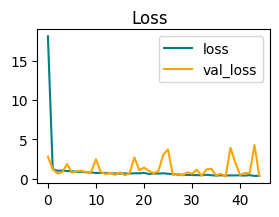

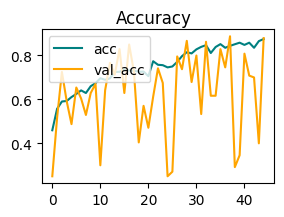

Fold Training Time: 2 hour(s) and 18 mins
Precision: 90.47619104385376  -  Recall: 87.08333373069763
Accuracy: 88.7499988079071
F1Score: Building 83.07691955566406 | Plant 92.06349182128906 | Road 94.7368392944336 | Vehicle 85.45454406738281
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/28350dab-be41-4c0a-b08e-434feddb41ff
Epoch 1/45
210/210 [==============================] - ETA: 0s - loss: 12.6688 - accuracy: 0.4917
Epoch 1: val_loss improved from inf to 3.46601, saving model to ./checkpoints/V4.1.0\FOLD-6
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-6\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-6\assets


210/210 [==============================] - 206s 954ms/step - loss: 12.6688 - accuracy: 0.4917 - val_loss: 3.4660 - val_accuracy: 0.2500 - lr: 0.0020
Epoch 2/45
210/210 [==============================] - ETA: 0s - loss: 1.0944 - accuracy: 0.5839
Epoch 2: val_loss improved from 3.46601 to 1.23958, saving model to ./checkpoints/V4.1.0\FOLD-6
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-6\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-6\assets


210/210 [==============================] - 222s 1s/step - loss: 1.0944 - accuracy: 0.5839 - val_loss: 1.2396 - val_accuracy: 0.4542 - lr: 0.0020
Epoch 3/45
210/210 [==============================] - ETA: 0s - loss: 0.9304 - accuracy: 0.6298
Epoch 3: val_loss improved from 1.23958 to 0.77612, saving model to ./checkpoints/V4.1.0\FOLD-6
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-6\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-6\assets


210/210 [==============================] - 201s 957ms/step - loss: 0.9304 - accuracy: 0.6298 - val_loss: 0.7761 - val_accuracy: 0.6500 - lr: 0.0020
Epoch 4/45
210/210 [==============================] - ETA: 0s - loss: 0.9841 - accuracy: 0.5708
Epoch 4: val_loss did not improve from 0.77612
210/210 [==============================] - 193s 918ms/step - loss: 0.9841 - accuracy: 0.5708 - val_loss: 1.1878 - val_accuracy: 0.5792 - lr: 0.0020
Epoch 5/45
210/210 [==============================] - ETA: 0s - loss: 0.9527 - accuracy: 0.6244
Epoch 5: val_loss did not improve from 0.77612
210/210 [==============================] - 192s 914ms/step - loss: 0.9527 - accuracy: 0.6244 - val_loss: 0.9364 - val_accuracy: 0.6875 - lr: 0.0020
Epoch 6/45
210/210 [==============================] - ETA: 0s - loss: 0.9527 - accuracy: 0.6077
Epoch 6: val_loss did not improve from 0.77612
210/210 [==============================] - 191s 911ms/step - loss: 0.9527 - accuracy: 0.6077 - val_loss: 0.8767 - val_accuracy:

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-6\assets


210/210 [==============================] - 198s 944ms/step - loss: 0.9785 - accuracy: 0.6173 - val_loss: 0.7395 - val_accuracy: 0.7125 - lr: 0.0020
Epoch 8/45
210/210 [==============================] - ETA: 0s - loss: 0.9358 - accuracy: 0.6238
Epoch 8: val_loss did not improve from 0.73950
210/210 [==============================] - 191s 912ms/step - loss: 0.9358 - accuracy: 0.6238 - val_loss: 1.0110 - val_accuracy: 0.5500 - lr: 0.0020
Epoch 9/45
210/210 [==============================] - ETA: 0s - loss: 0.8496 - accuracy: 0.6613
Epoch 9: val_loss did not improve from 0.73950
210/210 [==============================] - 191s 912ms/step - loss: 0.8496 - accuracy: 0.6613 - val_loss: 0.8237 - val_accuracy: 0.6833 - lr: 0.0020
Epoch 10/45
210/210 [==============================] - ETA: 0s - loss: 0.9011 - accuracy: 0.6417
Epoch 10: val_loss did not improve from 0.73950
210/210 [==============================] - 191s 911ms/step - loss: 0.9011 - accuracy: 0.6417 - val_loss: 1.5236 - val_accurac

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-6\assets


210/210 [==============================] - 199s 949ms/step - loss: 0.7367 - accuracy: 0.6857 - val_loss: 0.7200 - val_accuracy: 0.7542 - lr: 0.0020
Epoch 12/45
210/210 [==============================] - ETA: 0s - loss: 0.8468 - accuracy: 0.6476
Epoch 12: val_loss did not improve from 0.71997
210/210 [==============================] - 193s 917ms/step - loss: 0.8468 - accuracy: 0.6476 - val_loss: 2.5541 - val_accuracy: 0.4292 - lr: 0.0020
Epoch 13/45
210/210 [==============================] - ETA: 0s - loss: 0.7627 - accuracy: 0.6946
Epoch 13: val_loss did not improve from 0.71997
210/210 [==============================] - 191s 908ms/step - loss: 0.7627 - accuracy: 0.6946 - val_loss: 0.7762 - val_accuracy: 0.7833 - lr: 0.0020
Epoch 14/45
210/210 [==============================] - ETA: 0s - loss: 0.6604 - accuracy: 0.7274
Epoch 14: val_loss improved from 0.71997 to 0.70189, saving model to ./checkpoints/V4.1.0\FOLD-6
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-6\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-6\assets


210/210 [==============================] - 198s 943ms/step - loss: 0.6604 - accuracy: 0.7274 - val_loss: 0.7019 - val_accuracy: 0.6708 - lr: 0.0020
Epoch 15/45
210/210 [==============================] - ETA: 0s - loss: 0.7000 - accuracy: 0.7095
Epoch 15: val_loss did not improve from 0.70189
210/210 [==============================] - 191s 910ms/step - loss: 0.7000 - accuracy: 0.7095 - val_loss: 1.3349 - val_accuracy: 0.5125 - lr: 0.0020
Epoch 16/45
210/210 [==============================] - ETA: 0s - loss: 0.6838 - accuracy: 0.7190
Epoch 16: val_loss did not improve from 0.70189
210/210 [==============================] - 192s 912ms/step - loss: 0.6838 - accuracy: 0.7190 - val_loss: 1.8749 - val_accuracy: 0.3917 - lr: 0.0020
Epoch 17/45
210/210 [==============================] - ETA: 0s - loss: 0.5867 - accuracy: 0.7506
Epoch 17: val_loss did not improve from 0.70189
210/210 [==============================] - 192s 914ms/step - loss: 0.5867 - accuracy: 0.7506 - val_loss: 0.9039 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-6\assets


210/210 [==============================] - 199s 948ms/step - loss: 0.5618 - accuracy: 0.7833 - val_loss: 0.5728 - val_accuracy: 0.7833 - lr: 0.0020
Epoch 24/45
210/210 [==============================] - ETA: 0s - loss: 0.5363 - accuracy: 0.7893
Epoch 24: val_loss did not improve from 0.57281
210/210 [==============================] - 192s 914ms/step - loss: 0.5363 - accuracy: 0.7893 - val_loss: 0.6543 - val_accuracy: 0.7792 - lr: 0.0020
Epoch 25/45
210/210 [==============================] - ETA: 0s - loss: 0.4893 - accuracy: 0.8030
Epoch 25: val_loss did not improve from 0.57281
210/210 [==============================] - 191s 911ms/step - loss: 0.4893 - accuracy: 0.8030 - val_loss: 2.0983 - val_accuracy: 0.4208 - lr: 0.0020
Epoch 26/45
210/210 [==============================] - ETA: 0s - loss: 0.4936 - accuracy: 0.7988
Epoch 26: val_loss did not improve from 0.57281
210/210 [==============================] - 192s 913ms/step - loss: 0.4936 - accuracy: 0.7988 - val_loss: 1.2939 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-6\assets


210/210 [==============================] - 187s 892ms/step - loss: 0.4978 - accuracy: 0.8083 - val_loss: 0.4305 - val_accuracy: 0.8750 - lr: 0.0020
Epoch 29/45
210/210 [==============================] - ETA: 0s - loss: 0.4217 - accuracy: 0.8411
Epoch 29: val_loss did not improve from 0.43048
210/210 [==============================] - 180s 858ms/step - loss: 0.4217 - accuracy: 0.8411 - val_loss: 0.5173 - val_accuracy: 0.8083 - lr: 0.0020
Epoch 30/45
210/210 [==============================] - ETA: 0s - loss: 0.4721 - accuracy: 0.8292
Epoch 30: val_loss did not improve from 0.43048
210/210 [==============================] - 180s 858ms/step - loss: 0.4721 - accuracy: 0.8292 - val_loss: 2.5440 - val_accuracy: 0.3292 - lr: 0.0020
Epoch 31/45
210/210 [==============================] - ETA: 0s - loss: 0.4268 - accuracy: 0.8405
Epoch 31: val_loss did not improve from 0.43048
210/210 [==============================] - 180s 859ms/step - loss: 0.4268 - accuracy: 0.8405 - val_loss: 0.4569 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-6\assets


210/210 [==============================] - 187s 891ms/step - loss: 0.4155 - accuracy: 0.8405 - val_loss: 0.3738 - val_accuracy: 0.8542 - lr: 0.0020
Epoch 35/45
210/210 [==============================] - ETA: 0s - loss: 0.3865 - accuracy: 0.8571
Epoch 35: val_loss did not improve from 0.37385
210/210 [==============================] - 180s 855ms/step - loss: 0.3865 - accuracy: 0.8571 - val_loss: 0.4904 - val_accuracy: 0.8792 - lr: 0.0020
Epoch 36/45
210/210 [==============================] - ETA: 0s - loss: 0.4255 - accuracy: 0.8458
Epoch 36: val_loss did not improve from 0.37385
210/210 [==============================] - 181s 862ms/step - loss: 0.4255 - accuracy: 0.8458 - val_loss: 0.6664 - val_accuracy: 0.7708 - lr: 0.0020
Epoch 37/45
210/210 [==============================] - ETA: 0s - loss: 0.3968 - accuracy: 0.8571
Epoch 37: val_loss did not improve from 0.37385
210/210 [==============================] - 180s 859ms/step - loss: 0.3968 - accuracy: 0.8571 - val_loss: 0.4944 - val_acc

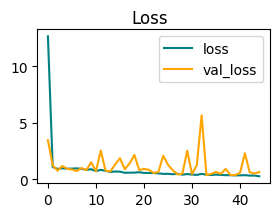

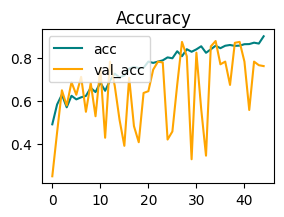

Fold Training Time: 2 hour(s) and 22 mins
Precision: 86.60714030265808  -  Recall: 80.83333373069763
Accuracy: 85.41666865348816
F1Score: Building 75.9259262084961 | Plant 91.05691528320312 | Road 90.16393280029297 | Vehicle 83.46456146240234
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/3f95085b-6582-4544-b6a9-61c97322a4eb
Epoch 1/45
210/210 [==============================] - ETA: 0s - loss: 15.2720 - accuracy: 0.4881
Epoch 1: val_loss improved from inf to 3.86928, saving model to ./checkpoints/V4.1.0\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-7\assets


210/210 [==============================] - 214s 994ms/step - loss: 15.2720 - accuracy: 0.4881 - val_loss: 3.8693 - val_accuracy: 0.2500 - lr: 0.0020
Epoch 2/45
210/210 [==============================] - ETA: 0s - loss: 1.2251 - accuracy: 0.5804
Epoch 2: val_loss improved from 3.86928 to 1.29288, saving model to ./checkpoints/V4.1.0\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-7\assets


210/210 [==============================] - 201s 960ms/step - loss: 1.2251 - accuracy: 0.5804 - val_loss: 1.2929 - val_accuracy: 0.4375 - lr: 0.0020
Epoch 3/45
210/210 [==============================] - ETA: 0s - loss: 0.8312 - accuracy: 0.6613
Epoch 3: val_loss improved from 1.29288 to 0.73871, saving model to ./checkpoints/V4.1.0\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-7\assets


210/210 [==============================] - 201s 958ms/step - loss: 0.8312 - accuracy: 0.6613 - val_loss: 0.7387 - val_accuracy: 0.6958 - lr: 0.0020
Epoch 4/45
210/210 [==============================] - ETA: 0s - loss: 0.8102 - accuracy: 0.6637
Epoch 4: val_loss improved from 0.73871 to 0.71964, saving model to ./checkpoints/V4.1.0\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-7\assets


210/210 [==============================] - 201s 955ms/step - loss: 0.8102 - accuracy: 0.6637 - val_loss: 0.7196 - val_accuracy: 0.6542 - lr: 0.0020
Epoch 5/45
210/210 [==============================] - ETA: 0s - loss: 0.7268 - accuracy: 0.6970
Epoch 5: val_loss did not improve from 0.71964
210/210 [==============================] - 193s 918ms/step - loss: 0.7268 - accuracy: 0.6970 - val_loss: 1.2231 - val_accuracy: 0.5125 - lr: 0.0020
Epoch 6/45
210/210 [==============================] - ETA: 0s - loss: 0.7049 - accuracy: 0.7274
Epoch 6: val_loss did not improve from 0.71964
210/210 [==============================] - 193s 920ms/step - loss: 0.7049 - accuracy: 0.7274 - val_loss: 0.8429 - val_accuracy: 0.6542 - lr: 0.0020
Epoch 7/45
210/210 [==============================] - ETA: 0s - loss: 0.6876 - accuracy: 0.7125
Epoch 7: val_loss improved from 0.71964 to 0.58400, saving model to ./checkpoints/V4.1.0\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-7\assets


210/210 [==============================] - 200s 951ms/step - loss: 0.6876 - accuracy: 0.7125 - val_loss: 0.5840 - val_accuracy: 0.7292 - lr: 0.0020
Epoch 8/45
210/210 [==============================] - ETA: 0s - loss: 0.6167 - accuracy: 0.7518
Epoch 8: val_loss did not improve from 0.58400
210/210 [==============================] - 194s 922ms/step - loss: 0.6167 - accuracy: 0.7518 - val_loss: 1.0438 - val_accuracy: 0.5917 - lr: 0.0020
Epoch 9/45
210/210 [==============================] - ETA: 0s - loss: 0.6136 - accuracy: 0.7565
Epoch 9: val_loss did not improve from 0.58400
210/210 [==============================] - 193s 917ms/step - loss: 0.6136 - accuracy: 0.7565 - val_loss: 0.7546 - val_accuracy: 0.6500 - lr: 0.0020
Epoch 10/45
210/210 [==============================] - ETA: 0s - loss: 0.5403 - accuracy: 0.7786
Epoch 10: val_loss did not improve from 0.58400
210/210 [==============================] - 193s 920ms/step - loss: 0.5403 - accuracy: 0.7786 - val_loss: 1.5463 - val_accurac

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-7\assets


210/210 [==============================] - 202s 960ms/step - loss: 0.4908 - accuracy: 0.8143 - val_loss: 0.5253 - val_accuracy: 0.8167 - lr: 0.0020
Epoch 17/45
210/210 [==============================] - ETA: 0s - loss: 0.4571 - accuracy: 0.8298
Epoch 17: val_loss did not improve from 0.52529
210/210 [==============================] - 193s 918ms/step - loss: 0.4571 - accuracy: 0.8298 - val_loss: 2.8921 - val_accuracy: 0.4583 - lr: 0.0020
Epoch 18/45
210/210 [==============================] - ETA: 0s - loss: 0.4423 - accuracy: 0.8339
Epoch 18: val_loss did not improve from 0.52529
210/210 [==============================] - 193s 918ms/step - loss: 0.4423 - accuracy: 0.8339 - val_loss: 0.7507 - val_accuracy: 0.7375 - lr: 0.0020
Epoch 19/45
210/210 [==============================] - ETA: 0s - loss: 0.4606 - accuracy: 0.8268
Epoch 19: val_loss did not improve from 0.52529
210/210 [==============================] - 194s 924ms/step - loss: 0.4606 - accuracy: 0.8268 - val_loss: 0.8839 - val_acc

INFO:tensorflow:Assets written to: ./checkpoints/V4.1.0\FOLD-7\assets


210/210 [==============================] - 200s 951ms/step - loss: 0.3110 - accuracy: 0.8839 - val_loss: 0.3239 - val_accuracy: 0.8750 - lr: 0.0012
Epoch 28/45
210/210 [==============================] - ETA: 0s - loss: 0.3086 - accuracy: 0.8923
Epoch 28: val_loss did not improve from 0.32386
210/210 [==============================] - 194s 922ms/step - loss: 0.3086 - accuracy: 0.8923 - val_loss: 0.4437 - val_accuracy: 0.8250 - lr: 0.0012
Epoch 29/45
210/210 [==============================] - ETA: 0s - loss: 0.2712 - accuracy: 0.8899
Epoch 29: val_loss did not improve from 0.32386
210/210 [==============================] - 194s 923ms/step - loss: 0.2712 - accuracy: 0.8899 - val_loss: 0.9101 - val_accuracy: 0.6792 - lr: 0.0012
Epoch 30/45
210/210 [==============================] - ETA: 0s - loss: 0.2573 - accuracy: 0.9018
Epoch 30: val_loss did not improve from 0.32386
210/210 [==============================] - 193s 919ms/step - loss: 0.2573 - accuracy: 0.9018 - val_loss: 1.2231 - val_acc

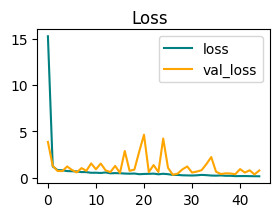

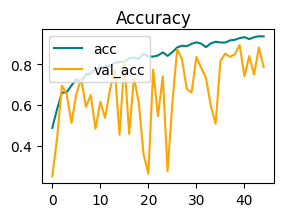

Fold Training Time: 2 hour(s) and 26 mins
Precision: 89.42731022834778  -  Recall: 84.58333611488342
Accuracy: 87.5
F1Score: Building 78.4313735961914 | Plant 93.65079498291016 | Road 93.33333587646484 | Vehicle 83.33332824707031
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
Total Training Time: 19 hour(s) and 29 mins


In [24]:
# ============================
# Log performance of each fold
# ============================

precisions = []
recalls = []
accuracies = []
f1_blds = []
f1_plants = []
f1_roads = []
f1_vhcls = []

counter = 0
start = perf_counter()
for train, test in kfold.split(train_x, train_y):
    start_fold = perf_counter()

    run = neptune.init_run(
        name= f"{model_name}-FOLD_{counter}",
        project=project_name,
        mode="offline"     # To prevent issue when internet sucks. Just manually sync it
    )  # your credentials

    run["parameters"] = params
    model = make_model(params)
    cat_y = tf.keras.utils.to_categorical(train_y)
    train_dataset = tf.data.Dataset.from_tensor_slices((train_x[train], cat_y[train]))
    train_fold = train_dataset.shuffle(buffer_size=train_dataset.cardinality(), seed=1).batch(params['batch_size'])
    
    test_dataset = tf.data.Dataset.from_tensor_slices((train_x[test], cat_y[test]))
    test_fold = test_dataset.shuffle(buffer_size=test_dataset.cardinality(), seed=1).batch(params['batch_size'])
    
    hist = model.fit(train_fold, 
                     validation_data=test_fold,
                     batch_size=params['batch_size'],
                     epochs=params['epochs'],
                     verbose=1,
                     callbacks=create_callbacks(counter))
    end_fold = perf_counter()

    # PLOTTING ==================================================
    run["fig-train_loss"].upload(plot_loss(hist))
    run["fig-train_acc"].upload(plot_acc(hist))
    
    # EVALUATING ==================================================
    model = tf.keras.models.load_model(checkpoint_path + str(counter))
    
    pre = Precision()
    rec = Recall()
    c_acc = CategoricalAccuracy()
    f1_score = F1Score()
    for batch in test_fold.as_numpy_iterator():
        X, y = batch
        yhat = model.predict(X, verbose=0)
        f1_score.update_state(y, yhat)
        pre.update_state(y, yhat)
        rec.update_state(y, yhat)
        c_acc.update_state(y, yhat)
        
    precisions.append(pre.result().numpy() * 100)
    recalls.append(rec.result().numpy() * 100)
    accuracies.append(c_acc.result().numpy() * 100)
    f1_s = f1_score.result().numpy() * 100
    
    f1_blds.append(f1_s[0])
    f1_plants.append(f1_s[1])
    f1_roads.append(f1_s[2])
    f1_vhcls.append(f1_s[3])
    
    run["eval/ACC/"] = accuracies[counter]
    run["eval/REC/"] = recalls[counter]
    run["eval/PRE/"] = precisions[counter]
    run["eval/F1-Bld"] = f1_blds[counter]
    run["eval/F1-Plant"] = f1_plants[counter]
    run["eval/F1-Road"] = f1_roads[counter]
    run["eval/F1-Vhcl"] = f1_vhcls[counter]
    
    # PRINTING RESULTS ===========================================
    print(f'Fold Training Time: {math.floor((end_fold-start_fold)/3600) } hour(s) and {math.floor((end_fold-start_fold)/60)%60} mins')
    print(f'Precision: {precisions[counter]}  -  Recall: {recalls[counter]}')
    print(f'Accuracy: {accuracies[counter]}')
    print(f'F1Score: Building {f1_blds[counter]} | Plant {f1_plants[counter]} | Road {f1_roads[counter]} | Vehicle {f1_vhcls[counter]}')
    
    run.stop()
    
    counter += 1

end = perf_counter()

print(f'Total Training Time: {math.floor((end-start)/3600) } hour(s) and {math.floor((end-start)/60)%60} mins')

# Get Average Performance of Model

## Save to Neptune AI

In [25]:
run = neptune.init_run(
        name= f"{model_name}-AVG",
        project=project_name,
        mode='offline',
        # api_token=api_token, # Api token is saved in user's environemnt variables
    )  # your credentials

run["eval/PRE/"] = avg_rate(precisions)
run["eval/REC/"] = avg_rate(recalls)
run["eval/ACC/"] = avg_rate(accuracies)
run["eval/F1-Bld"] = avg_rate(f1_blds)
run["eval/F1-Plant"] = avg_rate(f1_plants)
run["eval/F1-Road"] = avg_rate(f1_roads)
run["eval/F1-Vhcl"] = avg_rate(f1_vhcls)

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: offline/f06c2e08-2878-449a-b75e-32601752a39c
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!


## Save to Tensorboard

In [26]:
# Command to access TensorBoard HParams:

# tensorboard --logdir PATH/logs/hparam_tuning
with tf.summary.create_file_writer(f'./logs/hparam_tuning/{model_name}').as_default():
    hparams = {
        'CONV_F1': 32,
        'CONV_F2': 64,
        'CONV_F3': 128,
        'CONV_F4': 256,
        'DROPOUT': 0.2,
        'D_UNITS_1': 512,
        'DROPOUT': 0.2,
        'D_UNITS_2': 256,
    }
    hp.hparams(hparams)
    tf.summary.scalar('PRE', avg_rate(precisions), step=1)
    tf.summary.scalar('REC', avg_rate(recalls), step=1)
    tf.summary.scalar('ACC', avg_rate(accuracies), step=1)
    tf.summary.scalar('F1 - Building', avg_rate(f1_blds), step=1)
    tf.summary.scalar('F1 - Plant', avg_rate(f1_plants), step=1)
    tf.summary.scalar('F1 - Road', avg_rate(f1_roads), step=1)
    tf.summary.scalar('F1 - Vehicle', avg_rate(f1_vhcls), step=1)

# Asd

# Others

In [ ]:
model= make_model()
model.fit(
    x_train,
    y_train,
    validation_data=(x_test,y_test),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    callbacks=create_callbacks(0),
)

In [ ]:
true_test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
true_test_set = true_test_dataset.shuffle(buffer_size=true_test_dataset.cardinality(), seed=1).batch(64)

f1 = F1Score()
pre = Precision()
rec = Recall()
c_acc = CategoricalAccuracy()
for batch in true_test_set.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    yhat_max = []
    for i in yhat:
        maxed = np.argmax(i)
        yhat_max.append(maxed)
    yhat = np.array(yhat_max)
    f1.update_state(y, yhat)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    c_acc.update_state(y, yhat)


In [ ]:
run["eval/ACC/"] = float(c_acc.result().numpy() * 100)
run["eval/REC/"] = float(rec.result().numpy() * 100)
run["eval/PRE/"] = float(pre.result().numpy() * 100)


In [ ]:
run.stop()

In [ ]:
eval_metrics = model.evaluate(x_test, y_test, verbose=0)
for j, metric in enumerate(eval_metrics):
    run["eval/AVG-ACC/{}".format(model.metrics_names[j])] = metric

run.stop()

In [ ]:
for j, metric in enumerate(eval_metrics):
    print(model.metrics_names[j])

## Neptune AI Notes